# Goal
Predict whether the accepted loan would be properly paid back or not

log:
drop columns and load all data
move on to feature engineering


Make it better:
Can we use forward and backward or stepwise method to select the important parameter?

Should we treat ordinal value as catagory values or numeric values?


## import data

In [23]:
# load library
import pandas as pd
import numpy as np
import dask.dataframe as dd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
reader = pd.read_csv('accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', chunksize=10000)
mid=[]
for chunk in reader:
    chunk=chunk[chunk['loan_status'].apply( lambda x: x not in ['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]
    # drop columns with more than 50% missing values
    chunk.rename(columns={'verification_status_joint':'verified_status_joint'}, inplace=True)

    chunk = chunk.drop(columns= ['verified_status_joint','sec_app_mths_since_last_major_derog', 'sec_app_revol_util',
       'revol_bal_joint', 'sec_app_inq_last_6mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts',
       'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'dti_joint', 'annual_inc_joint',
       'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
       'mths_since_last_delinq'])

    #  drop columns with more than 20% of missing values
    chunk = chunk.drop(columns=['open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'])

    # drop column without explaination
    chunk = chunk.drop(columns=['debt_settlement_flag', 'debt_settlement_flag_date', 'deferral_term',\
         'disbursement_method', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_flag',\
            'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', \
            'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'open_act_il', \
            'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'sec_app_open_act_il',\
            'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term'])
    # drop column with high correlation
    chunk = chunk.drop(columns=['out_prncp_inv','funded_amnt','funded_amnt_inv','tot_hi_cred_lim','total_il_high_credit_limit'])
    # columns that are not related to prediction
    chunk = chunk.drop(columns=['url','desc','member_id','id','emp_title','sub_grade','zip_code','policy_code'])

    # drop column with date
    chunk = chunk.drop(columns= ['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','sec_app_earliest_cr_line'])

    mid.append(chunk)

accepted = pd.concat(mid)

/Users/livi/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/livi/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/livi/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/livi/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=inte

In [25]:
accepted.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,7746.0,2400.0
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,39475.0,79300.0
2,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,18696.0,6200.0
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,Source Verified,Current,...,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,52226.0,62500.0
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,...,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,95768.0,20300.0


In [26]:
# description from dataset:
data_descriptions = pd.read_excel('LCDataDictionary.xlsx', sheet_name=[0,1,2])

## Data Wrangling


In the following, we will try to analysis the column information and remvovee non-related columns. To do this, our first step is to understand the meaning of each column. The data set is acompanied with a well-documented data description. We will use it as a guideline.

### Remove columns that are not well defined

In [27]:
data_descriptions[0] = data_descriptions[0][['LoanStatNew', 'Description']]
data_descriptions[1].columns =['LoanStatNew', 'Description']
data_descriptions = pd.concat([data_descriptions[0], data_descriptions[1]], ignore_index=True)

In [28]:
# clearly there is an extra space need to be dealt with.
data_descriptions.LoanStatNew = data_descriptions.LoanStatNew.str.strip()
# verified status joint is called verification status joint in the dataset
accepted.rename(columns={'sverification_status_joint':'verified_status_joint'}, inplace=True)

In [29]:
data_descriptions = data_descriptions[[pd.notna(i) for i in data_descriptions.LoanStatNew]]

In [30]:
# check which column does not have an description
print('column name in data without description')
print(sorted(set(accepted.columns)-set(data_descriptions.LoanStatNew)))
print('*'*100)
print(sorted(set(data_descriptions.LoanStatNew)-set(accepted.columns)  ))
# The columns which does not contain a proper description will be removed. 

column name in data without description
[]
****************************************************************************************************
['accNowDelinq', 'accOpenPast24Mths', 'acceptD', 'addrState', 'all_util', 'annualInc', 'annual_inc_joint', 'bcOpenToBuy', 'bcUtil', 'creditPullD', 'delinq2Yrs', 'delinqAmnt', 'desc', 'dti_joint', 'earliestCrLine', 'earliest_cr_line', 'effective_int_rate', 'empLength', 'emp_title', 'expD', 'expDefaultRate', 'ficoRangeHigh', 'ficoRangeLow', 'fundedAmnt', 'funded_amnt', 'funded_amnt_inv', 'homeOwnership', 'id', 'il_util', 'ils_exp_d', 'initialListStatus', 'inqLast6Mths', 'inq_fi', 'inq_last_12m', 'intRate', 'isIncV', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'listD', 'loanAmnt', 'max_bal_bc', 'memberId', 'member_id', 'mortAcc', 'msa', 'mthsSinceLastDelinq', 'mthsSinceLastRecord', 'mthsSinceMostRecentInq', 'mthsSinceRecentBc', 'mthsSinceRecentLoanDelinq', 'mthsSinceRecentRevolDelinq', 'mths_since_last_delinq', 'mths_since_last_major_derog', 

In [31]:
# drop columns that do not have a proper explaination
accepted.drop(columns=list(set(accepted.columns)-set(data_descriptions.LoanStatNew)), inplace=True)
accepted.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,7746.0,2400.0
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,39475.0,79300.0
2,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,...,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,18696.0,6200.0
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,Source Verified,Current,...,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,52226.0,62500.0
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,...,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,95768.0,20300.0


### general examine data type

In [32]:
# earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d suppose to be datetime month_label-Year
#for col in ['earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d','issue_d','sec_app_earliest_cr_line']:
#    accepted[col] = pd.to_datetime(accepted[col], format='%b-%Y')

In [33]:
# convert id into object
#accepted[['id','policy_code']]=accepted[['id','policy_code']].astype('object')

In [34]:
# check dtypes
accepted.dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

In [35]:
# int
accepted.select_dtypes('int64').columns # id should be cat value
# <M8[ns]
datetime_dict={col: [ accepted[col].unique()] for col in accepted.select_dtypes('<M8[ns]').columns}
# float
float_dict={col: [ accepted[col].unique()] for col in accepted.select_dtypes('float64').columns}
# 0
object_dict={col: [accepted[col].unique()] for col in accepted.select_dtypes('O').columns}


### unique datetime
would not necessary for prediction

potential: time interval 

In [36]:
# unique datetime
pd.DataFrame.from_dict(datetime_dict, orient='index').rename(columns={0:'unique_values'})
date_col = ['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','sec_app_earliest_cr_line']

### unique object values
- identify columns that are not necessary: 
id, url, zip_code, grade/subgrade, title?, emp_title?


- test whether data type is proper or not
- define values for prediction
- clean nan values
- chisq independent test features

In [37]:
# unique object values
object_dict_unique = pd.DataFrame.from_dict(object_dict, orient='index').rename(columns={0:'unique_values'})
object_dict_unique['n']=object_dict_unique['unique_values'].apply(len)
object_dict_unique.sort_values("n")
# not related columns: id, url, desc

,unique_values,n
term,"[ 36 months, 60 months, nan]",3
pymnt_plan,"[n, y, nan]",3
initial_list_status,"[w, f, nan]",3
application_type,"[Individual, Joint App, nan]",3
verification_status,"[Not Verified, Source Verified, Verified, nan]",4
home_ownership,"[MORTGAGE, RENT, OWN, ANY, nan, NONE, OTHER]",7
grade,"[C, B, F, A, E, D, G, nan]",8
loan_status,"[Fully Paid, Current, Charged Off, In Grace Pe...",8
emp_length,"[10+ years, 3 years, 4 years, 6 years, 1 year,...",12
purpose,"[debt_consolidation, small_business, home_impr...",15


In [38]:
accepted['title'].str.lower().str.replace(' loan','').str.contains('loan').value_counts()

False    2229013
True        5583
Name: title, dtype: int64

In [39]:
stop_words1=['just','a','the','my','need','help','to', 'one', 'me', 'for','smart', 'jc', 'low', 'looking', 'lower', 'mike\'s', 'mike',\
    'michelle\'s', 'michelle', 'many', 'needed', 'mission', 'dad\'s', 'seeking', 'high', 'it', 'new', 'nice', 'and','quick','next','level', 'more',\
        'large','small','lendingclub','better', 'me', 'you','beautiful','easy', 'finally', 'rescue', 'get','first','last','second', 'up','lower',\
            'combine','little', 'project','please', 'thank', 'thanks','ny','of','is','are','i','on','&','this','in','me,','be','with','from','-',\
                'big','short','end','our', 'needs', 'bye','two','over','will','at','some','do','clear','combine','no','or']
accepted['title'] = accepted['title'].apply( lambda x: ' '.join([s for s in x.split() if (s not in stop_words1)]) if pd.notna(x) else x )

In [40]:
#### value recode
stop_words2=['lending club','no more','-','\s','\d','$','best','better','big','bye','final','buy','finish','going','good','great','hard','high',\
    'happy','honest','less','than','responsible','rich','right','short','long','smart','smile','term','want','unexpected','the','project','new','mine',
    'profit','first','second','expense']
accepted['title'] = accepted['title'].str.lower().str.replace(' loan','').str.replace('loan ','').str.strip('!,\'-.?&#$\/\ \\0123456789%:+=\"_)(')
accepted['title'] = accepted['title'].str.replace('c.c.','credit card')
accepted['title'] = accepted['title'].str.replace('lc','lending club')
accepted['title'] = accepted['title'].str.replace('cc','credit card')

for word in stop_words2:
    accepted['title'] = accepted['title'].str.replace(word,'')

In [41]:
#### grade and subgrade, if grade is empty, subgrade is empty
#accepted[['grade', 'sub_grade']].isna().sum(axis=1).unique()
#### moving is basically physically moving
accepted['title'][accepted['title'].apply(lambda x: 'moving' in x if pd.notna(x) else False)]
#### mustang is car
accepted['title'][accepted['title'].apply(lambda x: 'mustang' in x if pd.notna(x) else False)]
#### banks means people dont like the idea of bank
accepted['title'][accepted['title'].apply(lambda x: 'banks' in x if pd.notna(x) else False)]
#### mediacal is medial expanse
accepted['title'][accepted['title'].apply(lambda x: 'med' in x if pd.notna(x) else False)]
#### mba is school
accepted['title'][accepted['title'].apply(lambda x: 'mba' in x if pd.notna(x) else False)]

1347622                                      paymback
1612013                   afterexperienceiambackagain
1619962                             fundcombatveteran
1621280                   mbagraduate/timeconsolidate
1622451                businessopportunitymbagraduate
1627557                           addbathroombasement
1635565                                           mba
1637457                                           mba
1639472                                          mbas
1642135                        mbatexastechuniversity
1643741                        debtbusterfreedombanks
1643899                                   simbasmoney
1643980            mba,executive,perfectcredit,income
1644350                 ingmbawisconsinschoolbusiness
1644524                                        bambam
1644965                    gettingbacktrackheadingmba
1646009                                mbatopschoolmn
1647605                         mbaingconsolidatedebt
1648484                     

In [42]:
accepted['title'][accepted['title'].apply(lambda x: 'wash' in x if pd.notna(x) else False)].value_counts().head(40)

washer                                  4
washerdryer                             3
washer/dryer                            2
washerdryerfrigspa                      1
appliances!fridge,washerdryer           1
washer/dryerappliance                   1
washerdryerdogsurgerycarrepair          1
washingtondchome                        1
gettingawaywashingtonmutual             1
washingtondcrentalproperty              1
watercarwash                            1
debtwashout                             1
washingmachine                          1
expandingservicescarwash                1
kitchen/washer/dryer                    1
washingtonmutual/chasecreditcarddebt    1
movingwashingtondc                      1
waterheater,closwasher,furnace          1
savewashingtons                         1
partwasher                              1
artinstitutewashington                  1
houseexteriorrepaintingpowerwash        1
Name: title, dtype: int64

In [43]:
reword={'debt':['deb','debt','dedt','dbt','dept','bill','debit','wells','chase','citi','visa','bankamerica','bankofamerica','barclay','amex','american','boa','bofa','credit card',\
        'creditcard','credit','card','pay','pay-off','payoff','pay off','off','payback','paid','discover'],\
    'consolidation':['consolidation','con','cos','capitolslate','consalidadtion','conso','reconciliation','consoildation','consolidation','consolodation',\
        'consoldate','consolitation','consolidate','consol','cosolidation','onsolidation','recon','consol','refinance','refi','re-fi'],\
    'medical':['med','hospital','dental','health','surgery','dentist','rehab','headache','doctor'],\
    'wedding':['diamondring','wed','engage','honey','wedding','engagement','marr','ring'],\
    'mbuy':['mus','major','equip','daniel','defense','appliance','computer','laptop','camera','purchase','perchase','porchase',\
        'golf','boat','purchase','gun','software','seadoo','ship'],\
    'vehicle':['motor','dodge','harley','kawa','chevy','bmw','ford','toyota','wheels','honda','scooter','vehic','truck','mustang','subaru','suzuki',
        'mazda','auto','mercedes','auto','fuel','car','transmission','jeep','bike','trailer','subaru','nissan','engine','volvo','truck'],\
    'emergency':['emer','emr','emergency'],\
    'moving':['crossc','relo','moving','move'],\
    'law':['legal','attorney','law'],\
    'school':['edu','exam','training','classes','school','mba','mster\'s','student','graduate','phd','education','course','tuition','book','college',
        'teacher','program'], 
    'business':['farm','invent','business','buiness','buis','bus','bakery','shop','studio','web','buisness','company','busines','start-up',
        'startup','start up','inves'],\
    'home':['hous','heat','condo','chimney','apart','build','barn','basement','bassment','bath','boil','borrow',\
        'driveway','sewer','solar','property','cabin','yard','office','lawn','basement','renovat','home','mortgage','tub','pool','roof','rent',\
        'garage','bathroom','bedroom','kitchen','outdoor','suite','room','floor','ceil','garden','house','window','deck','fence','remodel','a/c','furniture','bed',
        'furnace','landscape','shelter','remo','tree','wash','lighttunnel'],\
    'personal':['presonal','pesonel','priv','peronal','personnel','personal','person','personal','vacation','money','cash','trip','pers','pes'],\
    'family':['child','adop','brother','sister','baby','mom','father','mother','grand','dad','daughter','kid','fam','funeral','myson'],\
    'other':['making','catch','eas','chan','fix','hop','impr','clear','com','never','add','bad','break','bright','help',\
        'bridge','sum','bless','blue','back','balan','insurance','together','all','goal','god','no','temp','self','free',\
        'live','lend','start','breath','day','clean','dream','love','peace','jan','feb','march','april','may','june','july',\
        'august','september','october','november','december','financ','redu','stres','soul','luck','month','opera','reduce',\
        'spring','time','out','plan','clos','capi','life','begin','mistake','sav','relief','air','tax','apr','interest','banks','green','vaction','simp']
        }



In [44]:
for k,v in reword.items():
    for item in v:
        accepted['title']=accepted['title'].apply(lambda x: (k if item in x else x) if isinstance(x,str) else x)


In [45]:
accepted['title'] = accepted['title'].replace({'or':'other','loan':'other','':'other','myloan':'other','future':'other','s':'other','k':'other',
'my':'other'})

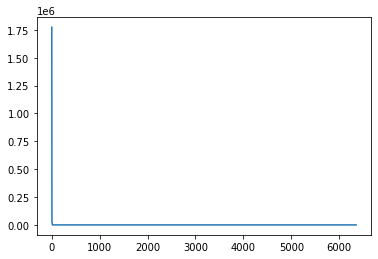

In [46]:
test = accepted[['title']].value_counts()
plt.plot(range(len(test)), test)

In [47]:
top10_index = [col[0] for col in accepted[['title']].value_counts().iloc[:10].index]
accepted['title'] = accepted['title'].apply(lambda x: (x if x in top10_index else 'other') if isinstance(x,str) else x)

In [48]:
#### title, emp_title
accepted[['title']].value_counts().head(20)
#[test.append(i[0].split()) if isinstance(i[0].split(),str) else test.extend(i[0].split()) for i in accepted[['title']].value_counts().keys()]
#from collections import Counter
#sorted(Counter(test).items(), key=lambda x: x[1], reverse=True)
#sorted(Counter(test).items(), key=lambda x: x[0])[6000:]

title        
debt             1774107
other             163204
home              162171
medical            26945
business           23702
vehicle            23696
personal           22233
consolidation      20449
moving             15221
wedding             2868
dtype: int64

In [49]:
#### emp title 436961 unique
#len(accepted['emp_title'].str.lower().value_counts())

In [50]:
not_related_cols = ['id','emp_title','sub_grade','zip_code','policy_code']
object_dict_unique

,unique_values,n
term,"[ 36 months, 60 months, nan]",3
grade,"[C, B, F, A, E, D, G, nan]",8
emp_length,"[10+ years, 3 years, 4 years, 6 years, 1 year,...",12
home_ownership,"[MORTGAGE, RENT, OWN, ANY, nan, NONE, OTHER]",7
verification_status,"[Not Verified, Source Verified, Verified, nan]",4
loan_status,"[Fully Paid, Current, Charged Off, In Grace Pe...",8
pymnt_plan,"[n, y, nan]",3
purpose,"[debt_consolidation, small_business, home_impr...",15
title,"[Debt consolidation, Business, nan, Major purc...",61686
addr_state,"[PA, SD, IL, NJ, GA, MN, SC, RI, TX, NC, CA, V...",52


#### define loan status value

**Column Explaination**

revolving loan: A revolving loan facility is a form of credit issued by a financial institution that provides the borrower with the ability to draw down or withdraw, repay, and withdraw again. A revolving loan is considered a flexible financing tool due to its repayment and re-borrowing accommodations.


**Loan status explaination**

Current: Loan is up to date on all outstanding payments. / any loan that is fully paid to date according to a contract.

Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 
 
In Grace Period: Loan is past due but within the 15-day grace period. 
 
Late (16-30): Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
Late (31-120): Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
Default: Loan has not been current for an extended period of time. 

Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.

Default and charged-off:
About 4-6 months after you miss your first payment, your loan will default and then charge-off. 

**From the defination above, charged off and default would be treated as default**


In [51]:
#unique value counts
accepted['loan_status'].value_counts()
# From the table bellow, does not meet the credit policy would be removed

Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40
Name: loan_status, dtype: int64

In [52]:
# remvove nan
accepted.dropna(subset=['loan_status'],inplace=True)

In [53]:
accepted['Default']=accepted['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off'] else 0).astype('object')

#### fill missing values

In [54]:
accepted[object_dict_unique.index].isnull().mean()*100
# drop verified_status_joint has more than 94 percent of missing values

term                   0.000000
grade                  0.000000
emp_length             6.504795
home_ownership         0.000000
verification_status    0.000000
loan_status            0.000000
pymnt_plan             0.000000
purpose                0.000000
title                  1.032942
addr_state             0.000000
initial_list_status    0.000000
application_type       0.000000
dtype: float64

In [106]:
#accepted.drop(columns='loan_status', inplace=True)
accepted['emp_length']=accepted['emp_length'].fillna(accepted['emp_length'].mode()[0])
accepted['title']=accepted['title'].fillna(accepted['title'].mode()[0])

### unique numeric values

In [62]:
# unique numeric values
float_dict_unique=pd.DataFrame.from_dict(float_dict, orient='index').rename(columns={0:'unique_values'})
float_dict_unique['n']=float_dict_unique['unique_values'].apply(len)

In [63]:
# find column with single value
float_dict_unique[float_dict_unique['n']==1].index
# single value: 'member_id'

Index([], dtype='object')

In [64]:
# find column with less than 10% of unique values. (1000 for 10000)
unique_index_1000=float_dict_unique[float_dict_unique['n']>1000].index

In [65]:
# display all columns
single_value_index=[]

numeric_cols=float_dict_unique.drop(index=single_value_index)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(numeric_cols.sort_values('n'))

# policy_code is cat value

,unique_values,n
num_tl_30dpd,"[0.0, 1.0, 2.0, 4.0, 3.0, nan]",6
num_tl_120dpd_2m,"[0.0, nan, 1.0, 2.0, 6.0, 3.0, 7.0, 4.0]",8
acc_now_delinq,"[0.0, 1.0, 2.0, 4.0, 3.0, 5.0, 6.0, 14.0, nan,...",10
inq_last_6mths,"[1.0, 4.0, 0.0, 3.0, 2.0, 5.0, 6.0, nan, 7.0, ...",10
chargeoff_within_12_mths,"[0.0, 1.0, 2.0, 3.0, 6.0, 7.0, 4.0, 5.0, 9.0, ...",12
pub_rec_bankruptcies,"[0.0, 1.0, 2.0, 3.0, 8.0, 4.0, 6.0, 5.0, 7.0, ...",13
collections_12_mths_ex_med,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 6.0,...",17
mths_since_recent_inq,"[4.0, 0.0, 10.0, nan, 1.0, 8.0, 14.0, 11.0, 18...",27
num_tl_op_past_12m,"[3.0, 2.0, 0.0, 1.0, 4.0, 12.0, 6.0, 5.0, 7.0,...",34
num_tl_90g_dpd_24m,"[0.0, 1.0, 2.0, 4.0, 12.0, 3.0, 7.0, 8.0, 5.0,...",35


#### check missing values

In [66]:
# percentage of 0s
float_zeros = pd.DataFrame((accepted[float_dict_unique.index]==0).mean())
float_zeros.columns=['percentage of 0s']

In [67]:
# remove all missing values
accepted.isnull().any(axis=1).sum()/2257952 # 0.9998609359277788 not possible to remove all rows.

0.26093070180411276

In [68]:
#  remove columns with missing  values more than 50%
float_dict_missing = accepted[float_dict_unique.index].isnull().mean()*100
float_dict_missing = float_dict_unique.join(float_dict_missing.rename('missing percentage'))

Text(0.5, 0, 'column names')

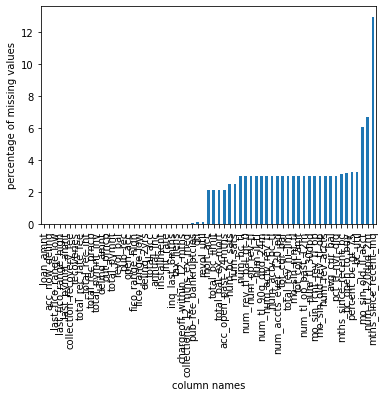

In [69]:
# histogram of misssing
float_dict_missing['missing percentage'].sort_values().plot(kind='bar')
plt.ylabel('percentage of missing values')
plt.xlabel('column names')

In [70]:
float_dict_missing[float_dict_missing['missing percentage']>20].index

Index([], dtype='object')

In [71]:
#  check the number of rows with full set of data
accepted[float_dict_missing.index].isnull().any(axis=1).sum()

464523

In [ ]:
'''
    def df_unique_missing_0s(df):
    numeric_cols=float_dict_unique.drop(index=single_value_index)
    # percentage of 0s
    float_zeros = pd.DataFrame((df[float_dict_unique.index]==0).mean())
    float_zeros.columns=['percentage of 0s']
    # missings
    float_dict_missing = df[float_dict_unique.index].isnull().mean()*100
    float_dict_missing = float_dict_unique.join(float_dict_missing.rename('missing percentage'))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(numeric_cols.join(float_zeros).join(float_dict_missing['missing percentage']).\
        sort_values(['missing percentage','percentage of 0s'], ascending=False))
'''

In [72]:
#accepted_trimed=accepted.drop(columns='mths_since_recent_inq').dropna()
# could not use trimed version because it significantly remove default data

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(numeric_cols.join(float_zeros).join(float_dict_missing['missing percentage']).\
        sort_values(['missing percentage','percentage of 0s'], ascending=False))

,unique_values,n,percentage of 0s,missing percentage
mths_since_recent_inq,"[4.0, 0.0, 10.0, nan, 1.0, 8.0, 14.0, 11.0, 18...",27,7.481535e-02,12.962644
num_tl_120dpd_2m,"[0.0, nan, 1.0, 2.0, 6.0, 3.0, 7.0, 4.0]",8,9.326012e-01,6.683499
mo_sin_old_il_acct,"[148.0, 113.0, 125.0, 36.0, 128.0, 338.0, 142....",567,7.086171e-06,6.037506
bc_util,"[37.2, 27.1, 55.9, 12.1, 77.5, 91.0, 102.9, 5....",1495,1.234987e-02,3.247326
percent_bc_gt_75,"[0.0, 7.7, 50.0, 60.0, 100.0, 28.6, 33.3, 25.0...",285,2.651605e-01,3.216679
bc_open_to_buy,"[1506.0, 57830.0, 2737.0, 54962.0, 4567.0, 844...",91501,1.362626e-02,3.197015
mths_since_recent_bc,"[4.0, 2.0, 101.0, 36.0, 12.0, 32.0, 50.0, 1.0,...",547,5.956812e-03,3.129563
pct_tl_nvr_dlq,"[76.9, 97.4, 100.0, 96.6, 96.3, 93.3, 95.7, 94...",691,5.757514e-06,2.997539
avg_cur_bal,"[20701.0, 9733.0, 31617.0, 23192.0, 27644.0, 2...",88598,4.012544e-04,2.993774
mo_sin_rcnt_rev_tl_op,"[3.0, 2.0, 14.0, 4.0, 32.0, 10.0, 1.0, 15.0, 9...",334,1.494606e-02,2.990718


#### check the correlation value

In [ ]:
accepted['Default'].value_counts()

In [ ]:
# check the correlation of the column that contains numeric values
accepted_numeric_corr = accepted[unique_index_1000].drop(columns=['recoveries','collection_recovery_fee']).corr()

plt.figure(figsize=(15,10))
sns.heatmap(accepted_numeric_corr,vmin=-1, vmax=1)

In [ ]:
accepted_numeric_corr_melt = accepted_numeric_corr.reset_index(drop=False).melt('index', var_name='var2', value_name='corr')
accepted_numeric_corr_melt = accepted_numeric_corr_melt.rename(columns={'index':'var1'})
highly_corr_cols = accepted_numeric_corr_melt[(abs(accepted_numeric_corr_melt['corr'])>0.8) & (accepted_numeric_corr_melt['var1']!=accepted_numeric_corr_melt['var2'])]
highly_corr_cols['combine'] = (highly_corr_cols['var1']+highly_corr_cols['var2']).apply(lambda x: ''.join(sorted(x)))

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    highly_corr_cols=highly_corr_cols.sort_values('corr', ascending=False).drop_duplicates(subset='combine')
    display(highly_corr_cols)

In [ ]:
for v1,v2 in highly_corr_cols[['var1','var2']].values:
    print(v1,v2)
    plt.figure()
    #plt.scatter(accepted[v1], accepted[[v1,v2]].groupby(v1).mean().reset_index()[v2])
    accepted[[v1,v2]].groupby(v1).mean().reset_index().plot(kind='scatter', x=v1,y=v2)
    plt.show()
# drop on in:
# out_prncp/out_prncp_inv; funded_amnt/loan_amnt; loan_amnt/funded_amnt_inv; tot_cur_bal/tot_hi_cred_lim;
# total_il_high_credit_limit/total_bal_ex_mort; 


In [ ]:
# out_prncp/out_prncp_inv; tot_cur_bal/tot_hi_cred_lim;
# total_il_high_credit_limit/total_bal_ex_mort; 
high_corr_cols = ['out_prncp_inv','funded_amnt','funded_amnt_inv','tot_hi_cred_lim','total_il_high_credit_limit']

**delinquent**: Delinquency means that you are behind on payments. Once you are delinquent for a certain period of time (usually nine months for federal loans), your lender will declare the loan to be in default. The entire loan balance will become due at that time.

**trades**: Trade finance represents the financial instruments and products that are used by companies to facilitate international trade and commerce.

#### fill missing

In [108]:
float_dict_missing[float_dict_missing['missing percentage']>0].sort_values('n', ascending=False)
# below 20 use mode, above 20 use median
for col in float_dict_missing.index:
    if float_dict_missing.loc[col,'n']>20:
        accepted[col].fillna(accepted[col].median(),inplace=True)
    else:
        accepted[col].fillna(accepted[col].mode()[0], inplace=True)

In [109]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(accepted.isnull().mean()).sort_values(0))

,0
loan_amnt,0.000000
mths_since_recent_inq,0.000000
mths_since_recent_bc,0.000000
mort_acc,0.000000
mo_sin_rcnt_tl,0.000000
mo_sin_rcnt_rev_tl_op,0.000000
mo_sin_old_rev_tl_op,0.000000
mo_sin_old_il_acct,0.000000
delinq_amnt,0.000000
chargeoff_within_12_mths,0.000000


## Feature Engineering